# Analisis de una serie de datos, paso a paso
## Cargar los datos

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
rcParams['figure.figsize'] = 15, 10
from pandas.plotting import register_matplotlib_converters
import plotly.express as px
import plotly.graph_objects as go
import random 
import statsmodels.api as sm
import datetime as dt

In [4]:
#Usamos Pandas para manejar las bases de Datos
#Importación de los datos a traves de Pandas
data = pd.ExcelFile('Serie de Ejercicios.xlsx')
print(data.sheet_names)  ###cuantas hojas hay


['Desocupados en miles', 'IPP', 'ISE', 'Colcap', 'PIB', 'Demanda Energía California']


In [5]:
#Data Frame de la hoja "Datos"
df=data.parse('ISE')

print(df) ###imprima los datos de la Hoja1
type(df)  ###el objeto es un dataframe 


      Año         Mes  Actividades primarias
0    2005       Enero              66.324084
1    2005     Febrero              62.294884
2    2005       Marzo              62.133014
3    2005       Abril              65.991723
4    2005        Mayo              64.775388
..    ...         ...                    ...
188  2020  Septiembre              97.967448
189  2020     Octubre              97.677131
190  2020   Noviembre              94.087678
191  2020   Diciembre             101.593772
192  2021       Enero              95.426727

[193 rows x 3 columns]


pandas.core.frame.DataFrame

## Preprocesamiento de los datos 

In [6]:
ind = pd.date_range(start='1/2005', end='2/2021', freq='M')
len(ind)
ISEts =pd.Series(df['Actividades primarias'].values,index=ind)
#SerieInt
type(ISEts)
print(ind)
print(ISEts)

193

pandas.core.series.Series

DatetimeIndex(['2005-01-31', '2005-02-28', '2005-03-31', '2005-04-30',
               '2005-05-31', '2005-06-30', '2005-07-31', '2005-08-31',
               '2005-09-30', '2005-10-31',
               ...
               '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31',
               '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30',
               '2020-12-31', '2021-01-31'],
              dtype='datetime64[ns]', length=193, freq='M')
2005-01-31     66.324084
2005-02-28     62.294884
2005-03-31     62.133014
2005-04-30     65.991723
2005-05-31     64.775388
                 ...    
2020-09-30     97.967448
2020-10-31     97.677131
2020-11-30     94.087678
2020-12-31    101.593772
2021-01-31     95.426727
Freq: M, Length: 193, dtype: float64


## Primeros gráficos

Text(0.5, 1.0, 'Valor del ISE')

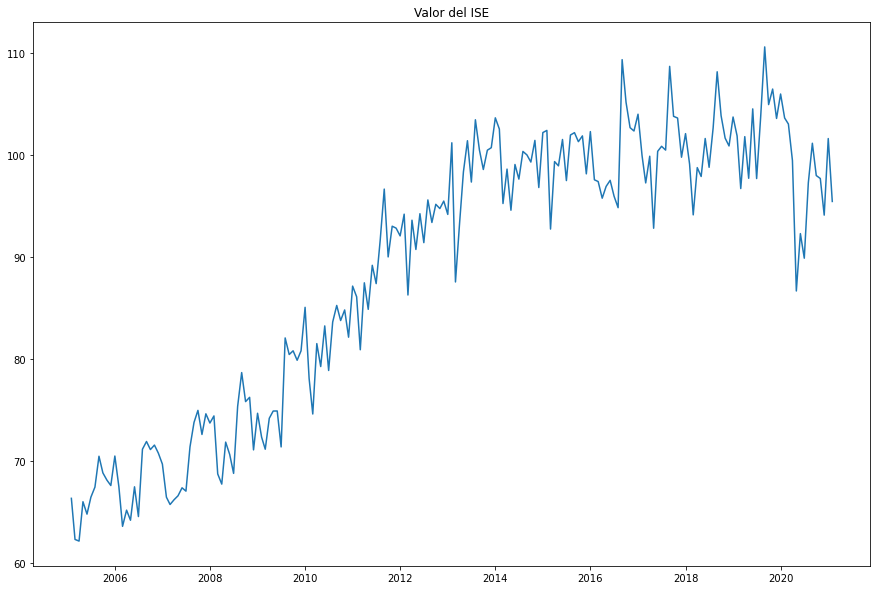

In [7]:
plt.plot(ISEts)
plt.title('Valor del ISE')

Parece que hay tendencia lineal, no es muy claro si hay ciclos estacionales porque entre el 2010 y el 2016 está muy ruidoso. Podria haber presencia de varianza no constante marginal.

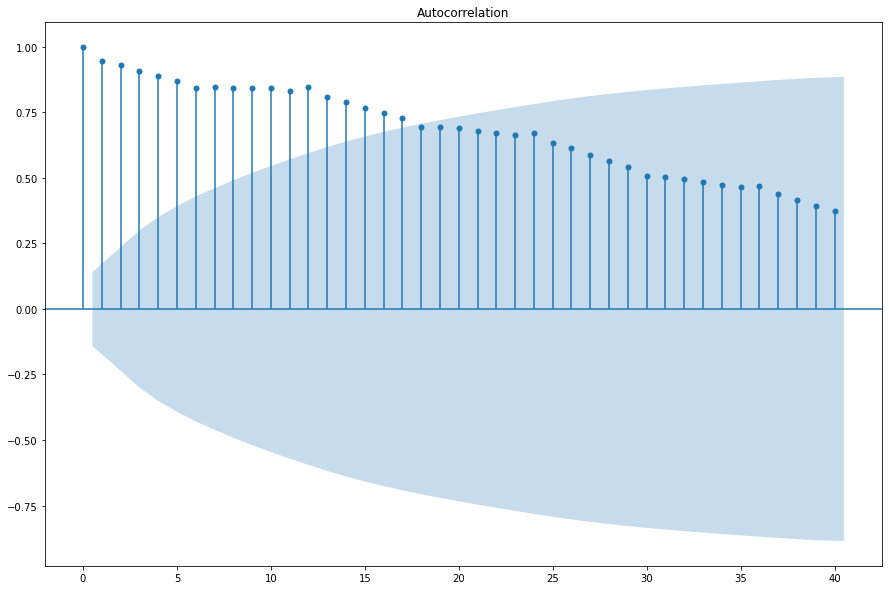

In [8]:
acfISE = plot_acf(ISEts, lags=40, adjusted=False)

Hay una fuerte estructura de correlación hasta el rezago 17. Veamos un gráfico

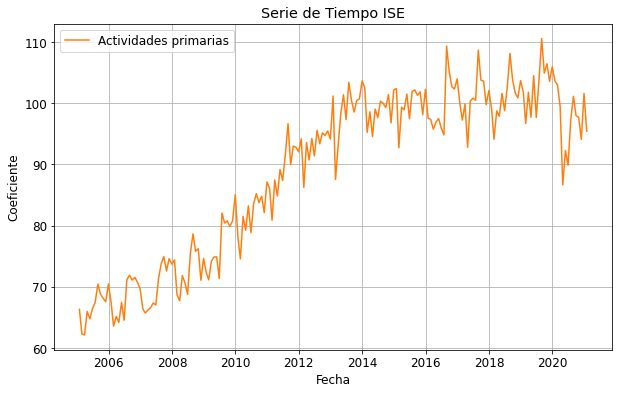

In [9]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(ISEts, color='tab:orange', label='Actividades primarias')
ax.set_xlabel('Fecha')
ax.set_ylabel('Coeficiente')
ax.set_title('Serie de Tiempo ISE')
ax.grid(True)
ax.legend(loc='upper left');

## Analisis de tendencia
¿Hay tendencia? ¿Se puede eliminar? Veamos

LinearRegression()

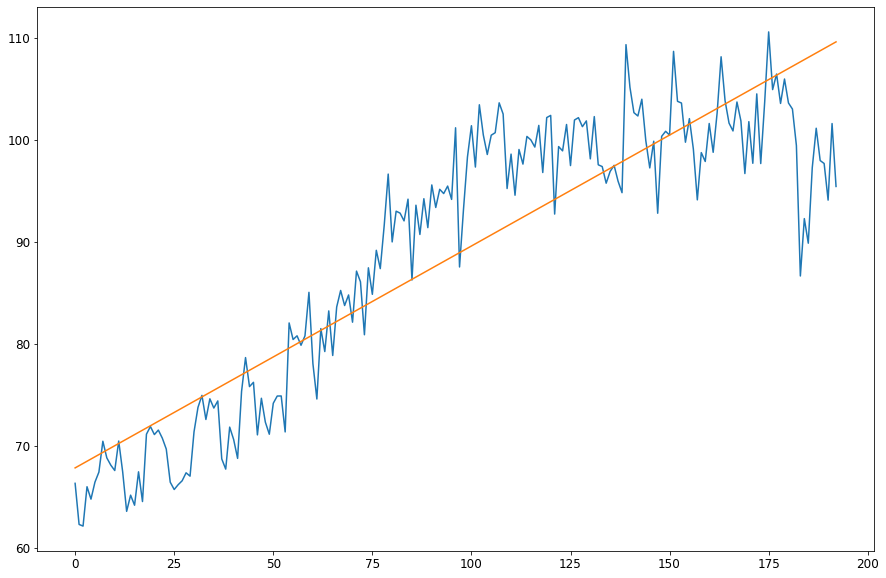

array([2.6102072])

-5165.627898964587

In [10]:
from sklearn.linear_model import LinearRegression
X1=np.arange(2005,2021+1/12,1/12)
X=X1
X = np.reshape(X, (len(X), 1))
y = ISEts.values
model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)
plt.plot(y)
plt.plot(trend)
plt.show()
model.coef_
model.intercept_

Ahora vamos a eliminar la tendencia

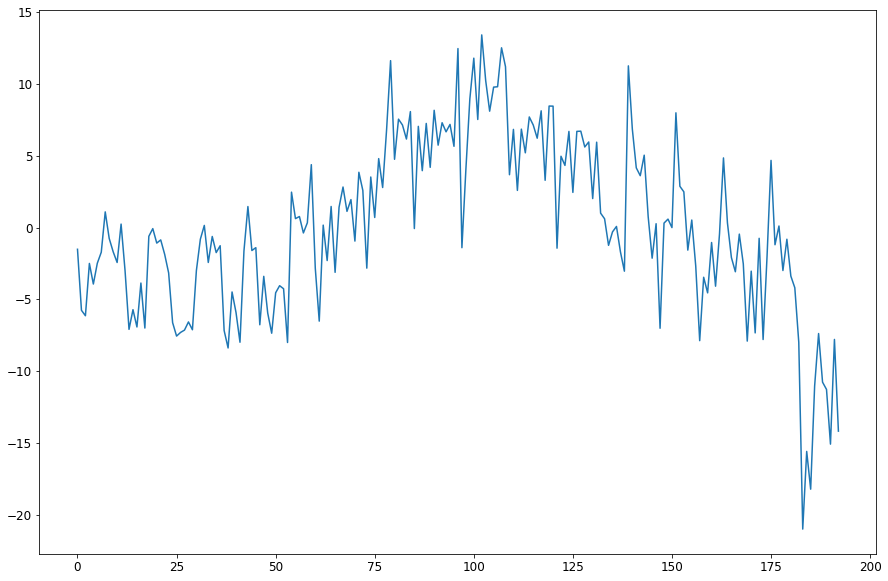

In [11]:
# detrend
detrended = [y[i]-trend[i] for i in range(0, len(ISEts))]
# plot detrended
plt.plot(detrended)
plt.show()
ISEdetrend=pd.Series(detrended,index=ISEts.index)

In [12]:
X = sm.add_constant(X)
linmodel = sm.OLS(y, X)
results = linmodel.fit()
print(results.summary())
ypred = results.predict(X)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     768.7
Date:                Thu, 22 Apr 2021   Prob (F-statistic):           7.14e-69
Time:                        15:27:53   Log-Likelihood:                -620.97
No. Observations:                 193   AIC:                             1246.
Df Residuals:                     191   BIC:                             1252.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5165.6279    189.516    -27.257      0.0

## El operador diferencia
La diferencia de orden 1 es ,
$$\nabla^1 Y_t=(1-B)^1 Y_t=Y_t-Y_{t-1}$$
 
La diferencia de orden 2 es,
$$\nabla^2 Y_t=(1-B)^2 Y_t=Y_t-2Y_{t-1}+T_{t-2}$$
 
y así sucesivamente siguiendo el teorema del binomio.

Vamos a aplicar el operador diferencia y a comparar los resultados entre eliminra la tendencia y diferenciar.

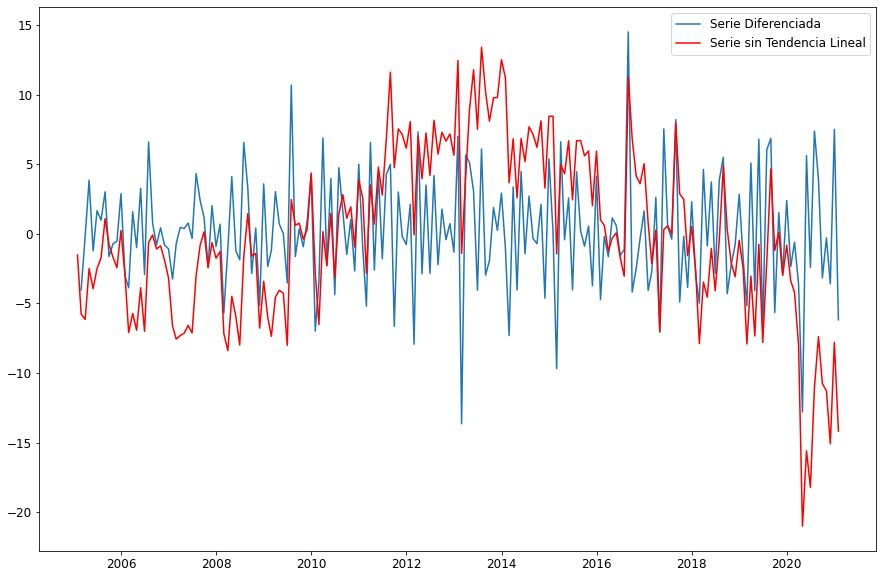

In [13]:
dif_ISEts=ISEts.diff(periods=1)

fig, ax = plt.subplots()
ax.plot(dif_ISEts, '-', label="Serie Diferenciada")
ax.plot(ISEdetrend, 'r', label="Serie sin Tendencia Lineal")
ax.legend(loc="best");

Claramente la serie diferenciada no tiene tendencia, y recordemos que será estacionaria.

## Graficos de autocorrelación

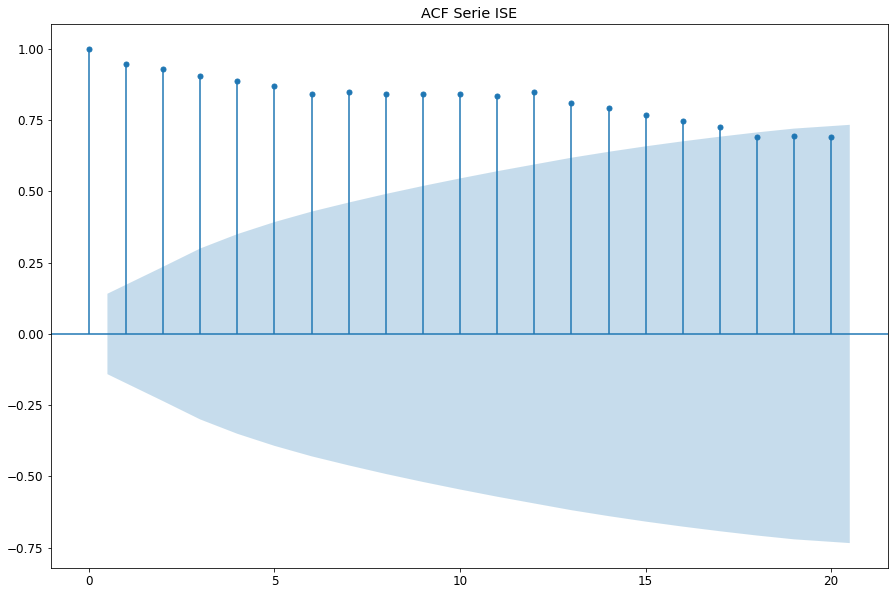

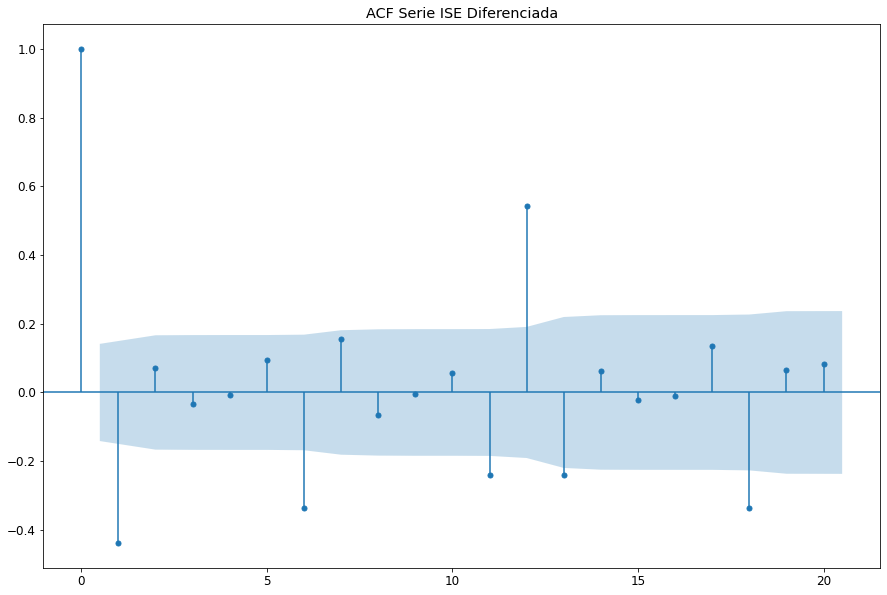

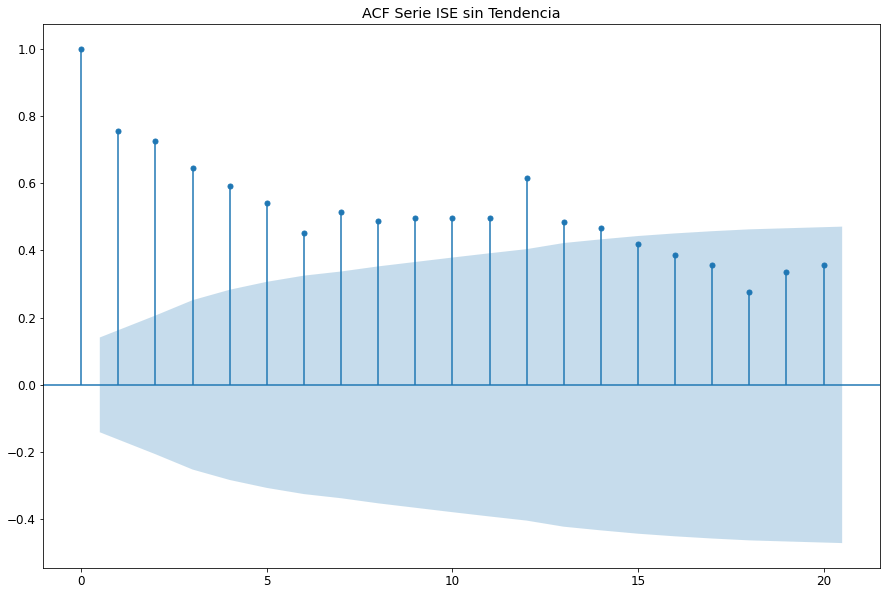

In [14]:
a=plot_acf(ISEts,adjusted=False,lags=20,title='ACF Serie ISE')
b=plot_acf(dif_ISEts.dropna(),adjusted=False,lags=20,title='ACF Serie ISE Diferenciada')
c=plot_acf(ISEdetrend,adjusted=False,lags=20,title='ACF Serie ISE sin Tendencia')

## Varianza marginal
### Transformación de Box-Cox para estabilizar la varianza
En ocasiones la serie presenta varianza marginal no constante a lo largo del tiempo, lo cual hace necesario tener en cuenta tal característica. 
En este caso, se siguiere hacer una transformación de potencia para estabilizar la varianza. Esta familia de transformaciones se llaman transformaciones Box-Cox.

\begin{equation}
	f_{\lambda}(u_{t})= \begin{cases}
		\lambda^{-1}(u^{\lambda}_{t}-1), &  \text{si  $u_{t} \geq 0$, para $\lambda>0$,}\\
		\ln(u_{t}), &\text{ si $u_{t}>0$, para $\lambda=0$}.
	\end{cases}
	\
\end{equation}

(array([ 60938.54723331,  50878.68564033,  50499.0260905 ,  60063.58968947,
         56931.49923265,  61242.87208334,  63899.95952196,  72501.65530329,
         67775.42423506,  65780.20127936,  64320.85316556,  72562.11620178,
         63954.75228416,  53954.99760622,  57922.51372041,  55433.68380817,
         63975.43774886,  56335.73321398,  74569.36831902,  76867.43173169,
         74460.51715513,  75791.68855303,  73408.80502438,  70245.74797315,
         61240.55189365,  59352.7628058 ,  60585.66432562,  61597.12828367,
         63710.33463312,  62825.49133932,  75250.86847482,  82772.6385076 ,
         86634.2257788 ,  79008.1991654 ,  85523.18577824,  82575.13203383,
         84837.69932187,  67483.89426079,  64702.944261  ,  76681.00358192,
         73017.55335277,  67636.08277463,  87938.51392297,  99547.74738856,
         89533.55357504,  90960.68627099,  74366.84551365,  85697.88331346,
         78190.58834008,  74560.57501643,  84083.34945075,  86422.02454181,
         864

Text(0.5, 1.0, 'Serie con Tranformación Box-Cox Ln')

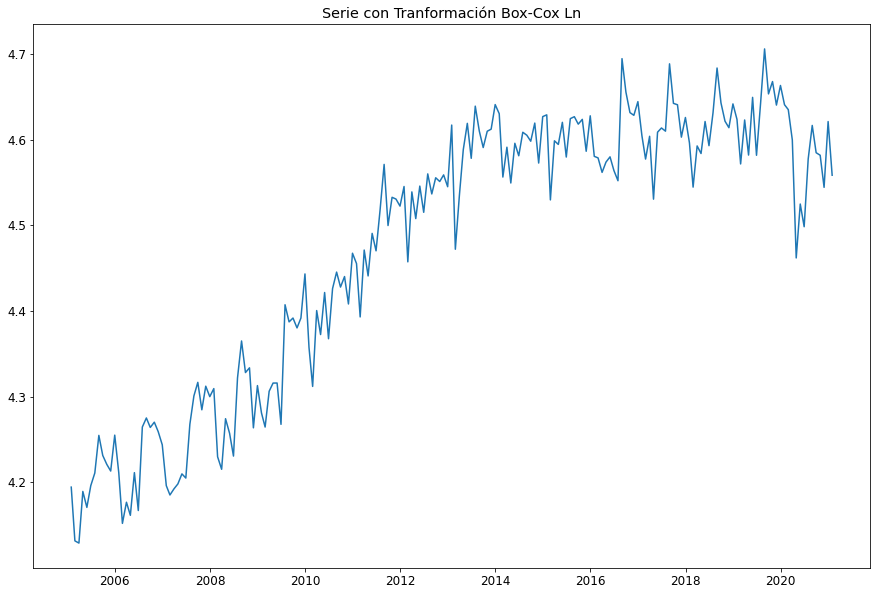

In [15]:
import scipy as sp
import scipy.stats ####En ocasiones puede funcionar la línea 46 sin ésta línea.
data = df
sp.stats.boxcox(data['Actividades primarias'],alpha=0.05)
logISE=sp.stats.boxcox(data['Actividades primarias'],lmbda=0)
data = data.assign(logISE=logISE)   

logcoise=data.set_index(pd.date_range(start='1/2005', end='2/2021', freq='M'))   
logISEco=  logcoise['logISE'] 
plt.plot(logISEco)
plt.title('Serie con Tranformación Box-Cox Ln') 
plt.show()


Como vemos en la salida del "sp.stats.boxcox" la transformación sugerida es con lambda mayor a 1, esto no es muy recomendable porque no hace gran cosa. Si el intervalo contiene al cero, o si esta entre 0 y 1 es importante hacer la transformación. Pero aquí la transformación no hizo nada.

In [16]:
sp.stats.boxcox(logISE,alpha=0.05)
###Note que la transformación Box-Cox nos muestra un lambda muy grande, porque desde antes no necesitabamos una transformación.

(array([16042326.04211179, 13115531.70250993, 13005455.60908572,
        15787138.48303685, 14874494.1070705 , 16131106.55682681,
        16906697.7921802 , 19421551.68832375, 18039123.76567982,
        17455955.16630839, 17029621.37389345, 19439244.07126382,
        16922699.26251465, 14008630.3844409 , 15163106.80624072,
        14438585.82670599, 16928740.24277057, 14701063.97246798,
        20026699.15428707, 20699426.67036486, 19994838.31222251,
        20384498.97815013, 19687022.58048272, 18761539.79068843,
        16130429.64740888, 15579893.08527811, 15939393.76627074,
        16234467.31722773, 16851322.72019148, 16592974.73453956,
        20226183.58326953, 22428527.98227894, 23559283.18023257,
        21326216.82916611, 23233958.41458594, 22370692.14050622,
        23033234.45225605, 17953895.95156008, 17141226.974214  ,
        20644847.12848296, 19572521.43988729, 17998386.99828402,
        23941172.939725  , 27338413.83339344, 24408154.84490923,
        24825933.83317058

## Graficas de retardos
Vamos a hacer gráficos de dispersión para chequear que tipos de relaciones hay entre los retardos de la variable interés. Nos podemos guiar del ACF pero no se confie del todo porque eso solo mira lo lineal.

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

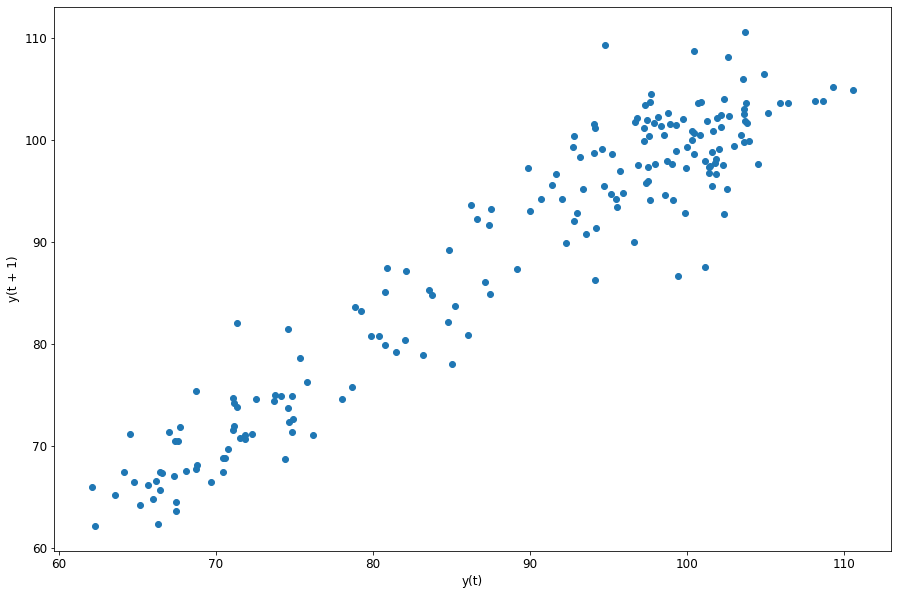

In [17]:
pd.plotting.lag_plot(ISEts, lag=1)

<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.0, 't vs t-1')

Text(0.5, 1.0, 't vs t-2')

Text(0.5, 1.0, 't vs t-3')

Text(0.5, 1.0, 't vs t-4')

Text(0.5, 1.0, 't vs t-5')

Text(0.5, 1.0, 't vs t-6')

Text(0.5, 1.0, 't vs t-7')

Text(0.5, 1.0, 't vs t-8')

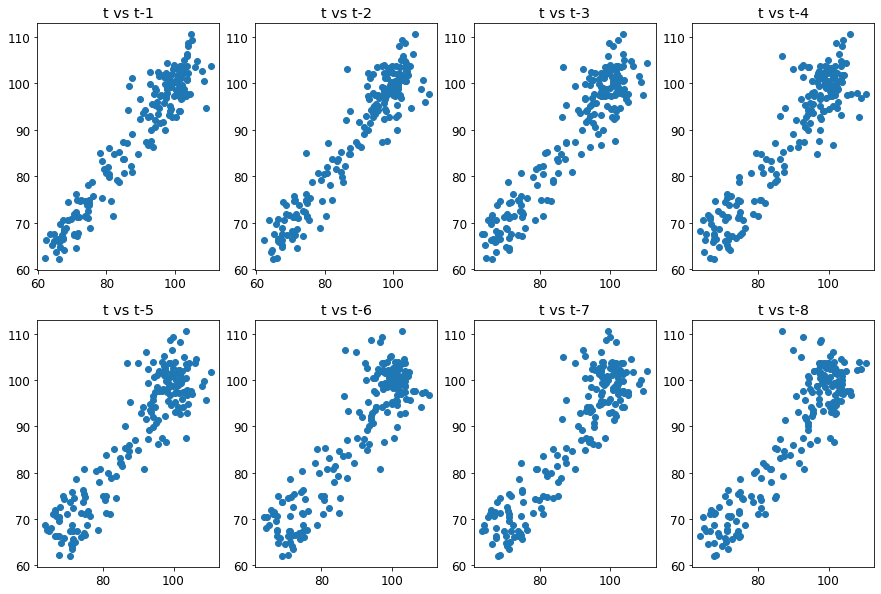

In [18]:
from pandas.plotting import scatter_matrix
values = pd.DataFrame(ISEts.values)
lags = 8
columns = [values]
for i in range(1,(lags + 1)):
	columns.append(values.shift(i))
dataframe = pd.concat(columns, axis=1)
columns = ['t']
for i in range(1,(lags + 1)):
	columns.append('t-' + str(i))
dataframe.columns = columns
plt.figure(1)
for i in range(1,(lags + 1)):
	ax = plt.subplot(240 + i)
	ax.set_title('t vs t-' + str(i))
	plt.scatter(x=dataframe['t'].values, y=dataframe['t-'+str(i)].values)
plt.show()

La relación con los rezagos es lineal, como vimos en el ACF está es la tendencia hasta el rezago 17 más o menos. Ahora unos gráficos más elegantes.

<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.0, 't vs t-1')

<AxesSubplot:title={'center':'t vs t-1'}>

Text(0.5, 1.0, 't vs t-2')

<AxesSubplot:title={'center':'t vs t-2'}>

Text(0.5, 1.0, 't vs t-3')

<AxesSubplot:title={'center':'t vs t-3'}>

Text(0.5, 1.0, 't vs t-4')

<AxesSubplot:title={'center':'t vs t-4'}>

Text(0.5, 1.0, 't vs t-5')

<AxesSubplot:title={'center':'t vs t-5'}>

Text(0.5, 1.0, 't vs t-6')

<AxesSubplot:title={'center':'t vs t-6'}>

Text(0.5, 1.0, 't vs t-7')

<AxesSubplot:title={'center':'t vs t-7'}>

Text(0.5, 1.0, 't vs t-8')

<AxesSubplot:title={'center':'t vs t-8'}>

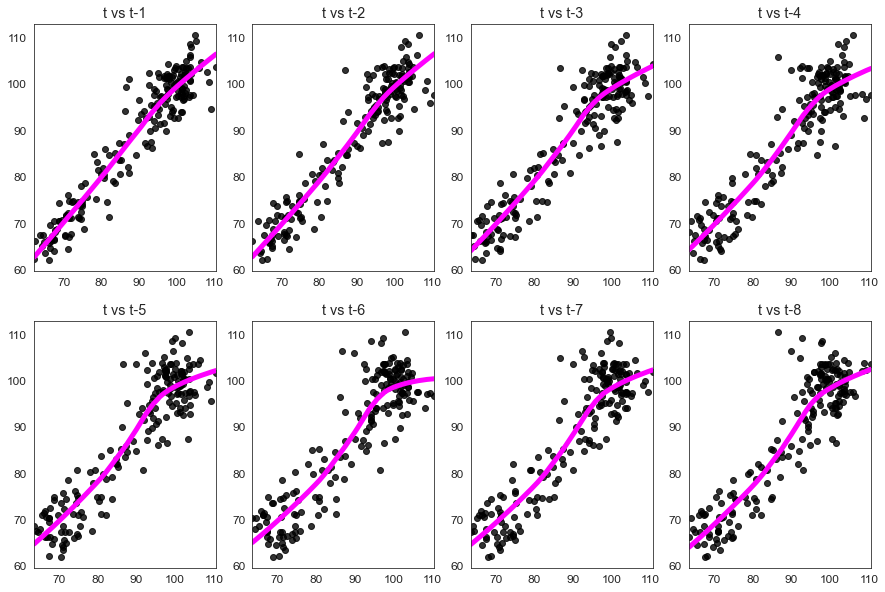

In [19]:
import seaborn as sns
sns.set_style("white")
from pandas.plotting import scatter_matrix
values = pd.DataFrame(ISEts.values)
lags = 8
columns = [values]
for i in range(1,(lags + 1)):
	columns.append(values.shift(i))
dataframe = pd.concat(columns, axis=1)
columns = ['t']
for i in range(1,(lags + 1)):
	columns.append('t-' + str(i))
dataframe.columns = columns
plt.figure(1)
for i in range(1,(lags + 1)):
	ax = plt.subplot(240 + i)
	ax.set_title('t vs t-' + str(i))
	sns.regplot(x=dataframe['t'].values, y=dataframe['t-'+str(i)].values,color="black",lowess=True, 
            line_kws={"color":"magenta", "linewidth":5})
plt.show()

Ahora con región de confianza

<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.0, 't vs t-1')

<AxesSubplot:title={'center':'t vs t-1'}>

Text(0.5, 1.0, 't vs t-2')

<AxesSubplot:title={'center':'t vs t-2'}>

Text(0.5, 1.0, 't vs t-3')

<AxesSubplot:title={'center':'t vs t-3'}>

Text(0.5, 1.0, 't vs t-4')

<AxesSubplot:title={'center':'t vs t-4'}>

Text(0.5, 1.0, 't vs t-5')

<AxesSubplot:title={'center':'t vs t-5'}>

Text(0.5, 1.0, 't vs t-6')

<AxesSubplot:title={'center':'t vs t-6'}>

Text(0.5, 1.0, 't vs t-7')

<AxesSubplot:title={'center':'t vs t-7'}>

Text(0.5, 1.0, 't vs t-8')

<AxesSubplot:title={'center':'t vs t-8'}>

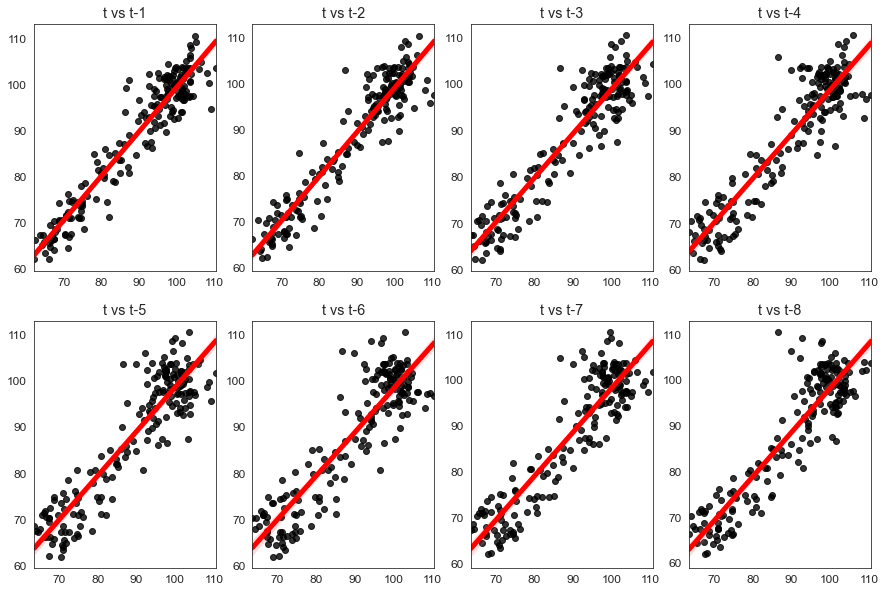

In [20]:
import seaborn as sns
sns.set_style("white")
from pandas.plotting import scatter_matrix
values = pd.DataFrame(ISEts.values)
lags = 8
columns = [values]
for i in range(1,(lags + 1)):
	columns.append(values.shift(i))
dataframe = pd.concat(columns, axis=1)
columns = ['t']
for i in range(1,(lags + 1)):
	columns.append('t-' + str(i))
dataframe.columns = columns
plt.figure(1)
for i in range(1,(lags + 1)):
	ax = plt.subplot(240 + i)
	ax.set_title('t vs t-' + str(i))
	sns.regplot(x=dataframe['t'].values, y=dataframe['t-'+str(i)].values,color="black", 
            line_kws={"color":"red", "linewidth":5})
plt.show()

## Función de autocorrelación simple
Cuando el proceso es estacionario, o al menos nompresenta tendencia, podemos usar el gráfico acf para explorar las posibles relaciones lineales a diferentes rezagos. En seguida mostramos la función de autocorrelación para el índice soi y la serie de nuevos peces.

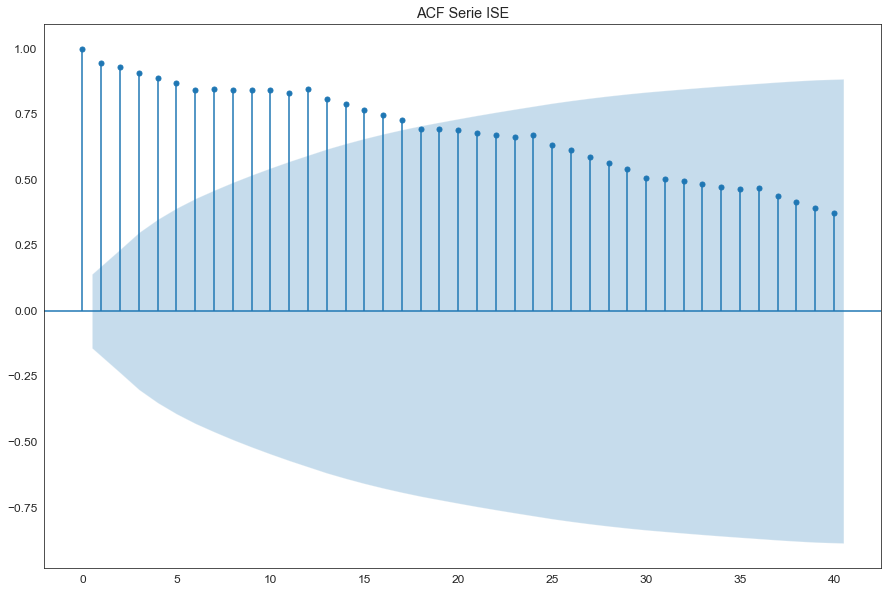

In [21]:
a=plot_acf(ISEts,adjusted=False,lags=40,title='ACF Serie ISE')

Aquí un poco diferente a lo de siempre

C:\Users\sanch\anaconda3\envs\d2l\lib\site-packages\pandas\plotting\_matplotlib\misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


(0.0, 40.0)

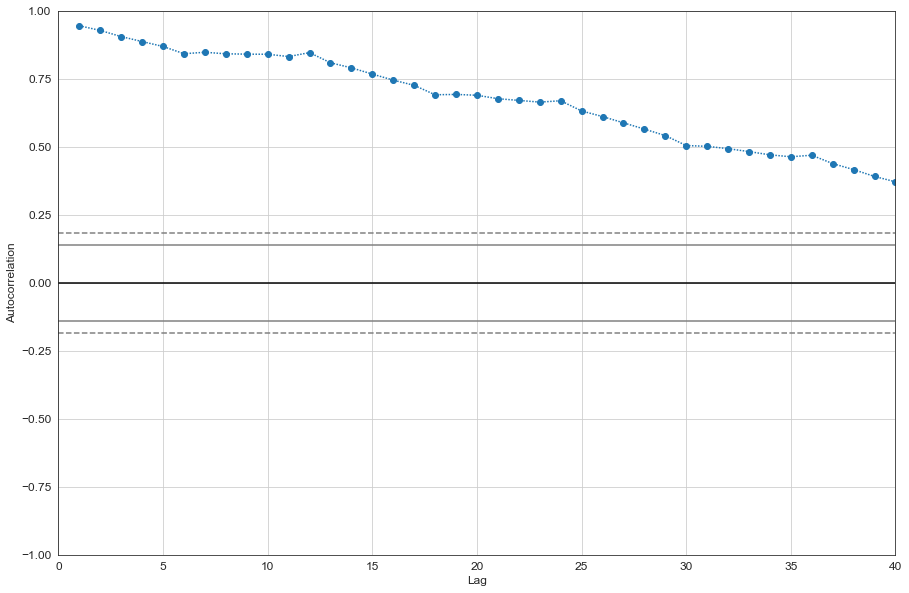

In [22]:
from pandas.plotting import autocorrelation_plot
ax =autocorrelation_plot(ISEts,marker="o",dashes= (1,0,0,1))
ax.set_xlim([0, 40])

## Estadísticas descriptivas y otras gráficas
Actividades primarias por mes, parece que no hay ciclo en los meses

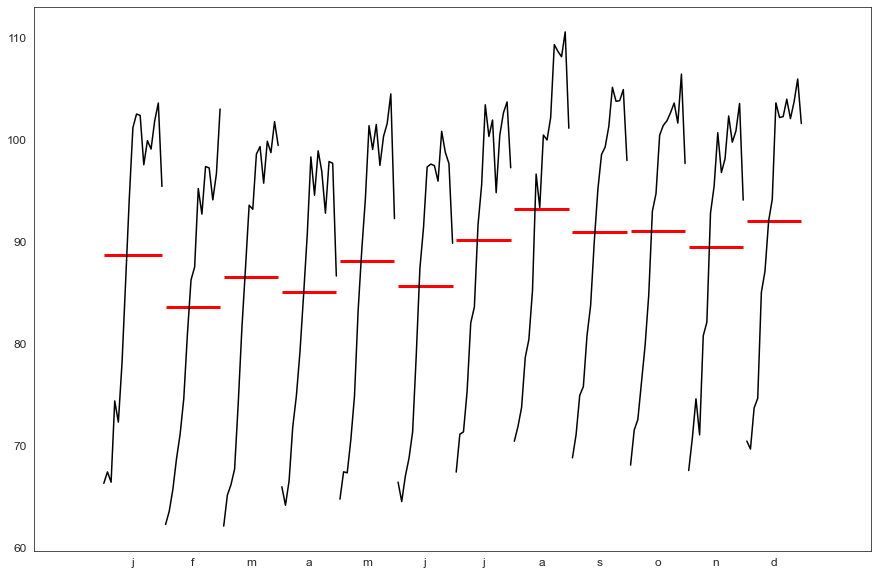

In [23]:
monthplot_ISE=sm.graphics.tsa.month_plot(ISEts)

### Estadísticas descriptivas
Vamos a mirar la media y la desviación estándar por mes, organizamos un dataframe con los factores años y meses

In [24]:
d = {'actprimarias': ISEts.values, 'fecha': ISEts.index,'year': ISEts.index.year,'mes':ISEts.index.month_name()}
df_ISE = pd.DataFrame(data=d)
df_ISE


d1 = {'actprimarias': ISEts.values, 'fecha': ISEts.index,'year':ISEts.index.year,'mes':ISEts.index.month}
df_ISE_1 = pd.DataFrame(data=d1)
df_ISE_1

,actprimarias,fecha,year,mes
0,66.324084,2005-01-31,2005,January
1,62.294884,2005-02-28,2005,February
2,62.133014,2005-03-31,2005,March
3,65.991723,2005-04-30,2005,April
4,64.775388,2005-05-31,2005,May
...,...,...,...,...
188,97.967448,2020-09-30,2020,September
189,97.677131,2020-10-31,2020,October
190,94.087678,2020-11-30,2020,November
191,101.593772,2020-12-31,2020,December


,actprimarias,fecha,year,mes
0,66.324084,2005-01-31,2005,1
1,62.294884,2005-02-28,2005,2
2,62.133014,2005-03-31,2005,3
3,65.991723,2005-04-30,2005,4
4,64.775388,2005-05-31,2005,5
...,...,...,...,...
188,97.967448,2020-09-30,2020,9
189,97.677131,2020-10-31,2020,10
190,94.087678,2020-11-30,2020,11
191,101.593772,2020-12-31,2020,12


Calculamos ahora las medias y las desviaciones estandar usando el group by y aplicando el .mean()

In [25]:
mediaspormes_ISE=df_ISE[['actprimarias','mes']].groupby(df_ISE['mes']).mean()
mediaspormes_ISE
nuevo={'ISEprom': mediaspormes_ISE['actprimarias'].values,'mes':mediaspormes_ISE.index}
df_mediaspormes_ISE=pd.DataFrame(data=nuevo)
df_mediaspormes_ISE

,actprimarias
mes,
April,85.125634
August,93.181515
December,92.018908
February,83.569306
January,88.753374
July,90.171429
June,85.704862
March,86.538172
May,88.116340


,ISEprom,mes
0,85.125634,April
1,93.181515,August
2,92.018908,December
3,83.569306,February
4,88.753374,January
5,90.171429,July
6,85.704862,June
7,86.538172,March
8,88.116340,May
9,89.465307,November


In [26]:
sdpormes_ISE=df_ISE[['actprimarias','mes']].groupby(df_ISE['mes']).std()
sdpormes_ISE

nuevo1={'actprimariassd': sdpormes_ISE['actprimarias'].values,'mes':sdpormes_ISE.index}
df_sdpormes_ISE=pd.DataFrame(data=nuevo1)
df_sdpormes_ISE

,actprimarias
mes,
April,12.834095
August,14.297196
December,13.383618
February,13.941687
January,14.486431
July,12.981579
June,13.718675
March,14.635722
May,14.435094


,actprimariassd,mes
0,12.834095,April
1,14.297196,August
2,13.383618,December
3,13.941687,February
4,14.486431,January
5,12.981579,July
6,13.718675,June
7,14.635722,March
8,14.435094,May
9,12.757073,November


Salieron en desorden, para graficar en orden de cada mes usamos el paquete sort_dataframeby_monthorweek, y hacemos el plot de las medias y las sd

In [27]:
#se deben instalar usando pip install sorted-months-weekdays y pip install sort-dataframeby-monthorweek
from sorted_months_weekdays import *
from sort_dataframeby_monthorweek import *

ModuleNotFoundError: No module named 'sorted_months_weekdays'

In [ ]:
Ordenado_medias_ISE=Sort_Dataframeby_Month(df = df_mediaspormes_ISE,  monthcolumnname='mes')
Ordenado_medias_ISE

Ordenado_sd_ISE=Sort_Dataframeby_Month(df = df_sdpormes_ISE,  monthcolumnname='mes')
Ordenado_sd_ISE

In [ ]:
plt.figure(figsize=(12, 5.5))
g = sns.barplot(data=Ordenado_medias_ISE, y='ISEprom', x='mes')
g.set_title('Media por mes del ISE')
g.set_xlabel('Mes')
g.set_ylabel('Promedio del ISE por mes')

In [ ]:
plt.figure(figsize=(12, 5.5))
g = sns.barplot(data=Ordenado_sd_ISE, y='actprimariassd', x='mes')
g.set_title('Desviación Estándar por mes del ISE')
g.set_xlabel('Mes')
g.set_ylabel('SD del ISE por mes')

Adicionalmente podemos hacer boxplot

In [ ]:
plt.figure(figsize=(12, 5.5))
g = sns.boxplot(data=df_ISE, y='actprimarias', x='mes')
g.set_title('Box Plot ISE por meses')
g.set_xlabel('Mes')
g.set_ylabel('ISE')

Ahora por año

In [ ]:
df= ISEts.reset_index()
df

In [ ]:
df['year'] = [d.year for d in df['index']]
df['month'] = [d.strftime('%b') for d in df['index']]
years = df['year'].unique()
df.columns
df_nuevo=df.rename(columns={'index':'Fecha',0:'ActPrimaria'})
df_nuevo

El grafico por años es

In [ ]:
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(16,12), dpi= 80)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'ActPrimaria', data=df_nuevo.loc[df_nuevo.year==y, :], color=mycolors[i], label=y)
        plt.text(df_nuevo.loc[df_nuevo.year==y, :].shape[0]-.9, df_nuevo.loc[df_nuevo.year==y, 'ActPrimaria'][-1:].values[0], y, fontsize=12, color=mycolors[i])

plt.gca().set(ylabel='$ISE', xlabel='$Mes$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Gráfico Estacional de la Serie de Tiempo ISE", fontsize=20)
plt.show()

In [ ]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='ActPrimaria', data=df_nuevo, ax=axes[0])
sns.boxplot(x='month', y='ActPrimaria', data=df_nuevo.loc[~df_nuevo.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Box Plot por año \n(The Trend)', fontsize=18); 
axes[1].set_title('Box Plot por mes \n(The Seasonality)', fontsize=18)
plt.show()

In [ ]:
#heatmap
df_nuevo_pivot = df_ISE.pivot("mes","year", "actprimarias")
ax = sns.heatmap(df_nuevo_pivot,cmap="Blues")

Los últimos gráficos se usaron para detectar ciclos, y en cada uno de esos vimos que no hay comportamiento ciclico. En el mapa de calor no hay ciclo en los meses, ni en los años, solamente hay tendencia lineal creciente a lo largo de los años. Que lo vimos más claramente en los boxplot y en los graficos estacionales por año porque todas tenian el mismo comportamiento "estacionario" pero a lo largo de los años crece

## Periodograma y detección de ciclos

In [ ]:
f, Pxx_den=sp.signal.periodogram(ISEts)
plt.plot(f, Pxx_den)
max_index_value = np.argmax(Pxx_den, axis=0)
print(max_index_value)
frecuencia_max=f[max_index_value]
print(frecuencia_max)

In [ ]:
f_welch, Pxx_den_welch=sp.signal.welch(ISEts)
plt.plot(f_welch, Pxx_den_welch)

## Suavizamiento en el contexto de series de tiempo
### Promedios moviles

In [ ]:
rolling_ISE = ISEts.rolling(window=7,win_type='boxcar').sum()
print(rolling_ISE[0:10])

In [ ]:
weights=np.array(np.r_[0.5,np.repeat(1,11),0.5],dtype=np.float64)*1/12
weights

In [ ]:
#EL MISMO QUE SE USO EN LAS ESTADISTICAS DESCRIPTIVAS
y_sums = np.convolve(ISEts,weights[::-1],'valid')
y_avg = np.true_divide(y_sums,weights.sum())

print(y_avg)
print(np.size(y_avg))

In [ ]:
print(ISEts)

In [ ]:
ISEts_pm=np.r_[np.repeat(np.nan, 6),y_avg,np.repeat(np.nan, 6)]
ind = pd.date_range(start='1/2005', end='2/2021', freq='M')
len(ind)
ISEts_pm =pd.Series(ISEts_pm,index=ind)
ISEts_pm[0:10]

In [ ]:

fig, ax = plt.subplots()
ax.plot(ISEts, '-', label="Serie ISE")
ax.plot(ISEts_pm, 'r', label="Serie suavizada")
ax.legend(loc="best");

### Suavizamiento kernel

In [ ]:
from statsmodels.nonparametric.kernel_regression import KernelReg

In [ ]:
n = ISEts.shape[0]
kde = KernelReg(endog=ISEts, exog=np.arange(n), var_type='c', bw=[12],reg_type='lc',ckertype='gaussian')

estimator = kde.fit(np.arange(n))
estimator = np.reshape(estimator[0],n)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(ISEts.index, ISEts, '-',alpha=0.5)
ax.plot(ISEts.index, estimator, '-', color='tab:red', alpha=0.8)

### Lowess

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess


Curva suave

In [ ]:
lowess_ISE = lowess(ISEts, np.arange(n), is_sorted=True, frac=0.05, it=0)
lowess_x = list(zip(*lowess_ISE))[0]
lowess_y = list(zip(*lowess_ISE))[1]

Tendencia

In [ ]:
lowess_ISE_1 = lowess(ISEts, np.arange(n), is_sorted=True,  it=0)
lowess_x_1 = list(zip(*lowess_ISE_1))[0]
lowess_y_1 = list(zip(*lowess_ISE_1))[1]

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(ISEts.index, ISEts, '-')
ax.plot(ISEts.index, lowess_y, '-', color='tab:red')
ax.plot(ISEts.index, lowess_y_1, '-', color='tab:green')


### Spliness

In [ ]:
from patsy import dmatrix 
# generating cubic spline with df=6 que está relacionado con el número de nodos
transformed_x = dmatrix("bs(train, df=6, degree=3, include_intercept=False)", {"train": np.arange(n)}, return_type='dataframe')
fit1 = sm.GLM(ISEts.values, transformed_x).fit()


In [ ]:
# generating cubic spline with df=6 que está relacionado con el número de nodos
transformed_x_1 = dmatrix("bs(train, df=4, degree=3, include_intercept=False)", {"train": np.arange(n)}, return_type='dataframe')
fit2 = sm.GLM(ISEts.values, transformed_x_1).fit()


In [ ]:
###Predicción
xp = np.linspace(np.arange(n).min(), np.arange(n).max(), np.size(np.arange(n)))
pred1 = fit1.predict(dmatrix("bs(xp,df=6, include_intercept=False)", {"xp":xp}, return_type='dataframe'))
pred2 = fit2.predict(dmatrix("bs(xp, df=4, include_intercept=False)", {"xp":xp}, return_type='dataframe'))

In [ ]:
plt.plot(ISEts.index, ISEts, alpha=0.25)
plt.plot(ISEts.index, pred1, label='Especificado con df=6')
plt.plot(ISEts.index, pred2, label='Especificado con df=4')
plt.legend()
plt.show()

## 3 Modelos para ajustar la serie de tiempo
Vamos a ajustar un modelo de redes neuronales, uno de arboles de decisión y una descomposición

### Descomposición usando suavizamiento exponencial
Aquí la única transformación (si se necesita) es transformación Box-Cox, de resto todo lo coge

In [ ]:
####Holt-Winters
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt  #suavizamiento exponencial

#print(pd.infer_freq(data['Month'], warn=True))
fit1 = ExponentialSmoothing(ISEts, seasonal_periods=12, trend='add', seasonal='add', initialization_method="estimated",use_boxcox=False).fit()  
#metemos la serie, hacemos explicita la frecuencia de cada cuanto observa

####ejecutar desde la línea 74 hasta la 88
plt.subplot(5, 1, 1)
plt.plot(ISEts)
plt.ylabel('ISE') 
plt.subplot(5, 1, 2)
plt.plot(fit1.level)
plt.ylabel('level') 
plt.subplot(5, 1, 3)
plt.plot(fit1.slope)
plt.ylabel('slope') 
plt.subplot(5, 1, 4)
plt.plot(fit1.season)
plt.ylabel('sesaon') 
plt.subplot(5, 1, 5)
plt.plot(fit1.resid)
plt.ylabel('resid') 

In [ ]:
fit1.params_formatted

In [ ]:
fcast1 = fit1.forecast(20).rename("Pronósticos")
ax = ISEts.plot(color="black", marker="o", figsize=(14,10))
fcast1.plot(ax=ax, color='blue', marker="o", legend=True)

### Arboles de decisión
Se necesita una serie sin tendencia, entonces podemos usar la serie detrend o diferenciada, sin embargo al hacer los pronosticos debemos volver a la escala original (hacer la transformación "inversa"). 

En R la transformación inversa de diferenciar es diffinv. y de boxcox es boxcox.inv,  invBoxCox(z, lambda, sign.y, GeometricMean, rescale)

En python es pmdarima.utils.diff_inv, y de boxcox es inv_boxcox

In [ ]:
print(ISEdetrend)
print(dif_ISEts)
#ISEdetrend=pd.Series(detrended,index=ISEts.index)

In [ ]:
acfISE = plot_acf(ISEdetrend, lags=100, adjusted=False)
acfIsedif = plot_acf(dif_ISEts.dropna(), lags=100, adjusted=False)

In [28]:
from pandas import DataFrame
# reframe as supervised learning
# lag observation (t-1) is the input variable and t is the output variable.
df1 = DataFrame()
print(df1)

Empty DataFrame
Columns: []
Index: []


Vamos a usar la serie diferenciada porque la serie sin tendencia no está del todo bien.

In [29]:
#data = pd.ExcelFile('Serie de Ejercicios.xlsx')
#df=data.parse('ISE')
ind = pd.date_range(start='1/2005', end='2/2021', freq='M')
ISEdf =pd.DataFrame(dif_ISEts.values,index=ind)
type(ISEdf)
print(ISEdf)

pandas.core.frame.DataFrame

                   0
2005-01-31       NaN
2005-02-28 -4.029199
2005-03-31 -0.161871
2005-04-30  3.858710
2005-05-31 -1.216335
...              ...
2020-09-30 -3.166391
2020-10-31 -0.290317
2020-11-30 -3.589453
2020-12-31  7.506095
2021-01-31 -6.167045

[193 rows x 1 columns]


In [30]:
## tenemos los rezagos de las 15 primeras, segun lo que salio en el acf
for i in range(13,0,-1):
    df1[['t-'+str(i)]] = ISEdf.shift(i)

In [31]:
print(df1)

                t-13      t-12      t-11      t-10        t-9        t-8  \
2005-01-31       NaN       NaN       NaN       NaN        NaN        NaN   
2005-02-28       NaN       NaN       NaN       NaN        NaN        NaN   
2005-03-31       NaN       NaN       NaN       NaN        NaN        NaN   
2005-04-30       NaN       NaN       NaN       NaN        NaN        NaN   
2005-05-31       NaN       NaN       NaN       NaN        NaN        NaN   
...              ...       ...       ...       ...        ...        ...   
2020-09-30  6.862740 -5.653782  1.521942 -2.880696   2.394631  -2.349176   
2020-10-31 -5.653782  1.521942 -2.880696  2.394631  -2.349176  -0.593144   
2020-11-30  1.521942 -2.880696  2.394631 -2.349176  -0.593144  -3.577843   
2020-12-31 -2.880696  2.394631 -2.349176 -0.593144  -3.577843 -12.788150   
2021-01-31  2.394631 -2.349176 -0.593144 -3.577843 -12.788150   5.624123   

                  t-7        t-6        t-5       t-4       t-3       t-2  \
2005-01-31

In [32]:
# Create column t
df1['t'] = ISEdf.values
print(df1.head(13))

            t-13  t-12      t-11      t-10       t-9       t-8       t-7  \
2005-01-31   NaN   NaN       NaN       NaN       NaN       NaN       NaN   
2005-02-28   NaN   NaN       NaN       NaN       NaN       NaN       NaN   
2005-03-31   NaN   NaN       NaN       NaN       NaN       NaN       NaN   
2005-04-30   NaN   NaN       NaN       NaN       NaN       NaN       NaN   
2005-05-31   NaN   NaN       NaN       NaN       NaN       NaN       NaN   
2005-06-30   NaN   NaN       NaN       NaN       NaN       NaN       NaN   
2005-07-31   NaN   NaN       NaN       NaN       NaN       NaN       NaN   
2005-08-31   NaN   NaN       NaN       NaN       NaN       NaN       NaN   
2005-09-30   NaN   NaN       NaN       NaN       NaN       NaN -4.029199   
2005-10-31   NaN   NaN       NaN       NaN       NaN -4.029199 -0.161871   
2005-11-30   NaN   NaN       NaN       NaN -4.029199 -0.161871  3.858710   
2005-12-31   NaN   NaN       NaN -4.029199 -0.161871  3.858710 -1.216335   
2006-01-31  

In [33]:
# Create a new subsetted dataframe, removing Nans from first 370 rows
df1_ISE = df1[14:]
print(df1_ISE)
df1_ISE.size

                t-13      t-12      t-11      t-10        t-9        t-8  \
2006-03-31 -4.029199 -0.161871  3.858710 -1.216335   1.663566   0.987467   
2006-04-30 -0.161871  3.858710 -1.216335  1.663566   0.987467   3.023846   
2006-05-31  3.858710 -1.216335  1.663566  0.987467   3.023846  -1.630526   
2006-06-30 -1.216335  1.663566  0.987467  3.023846  -1.630526  -0.710640   
2006-07-31  1.663566  0.987467  3.023846 -1.630526  -0.710640  -0.528734   
...              ...       ...       ...       ...        ...        ...   
2020-09-30  6.862740 -5.653782  1.521942 -2.880696   2.394631  -2.349176   
2020-10-31 -5.653782  1.521942 -2.880696  2.394631  -2.349176  -0.593144   
2020-11-30  1.521942 -2.880696  2.394631 -2.349176  -0.593144  -3.577843   
2020-12-31 -2.880696  2.394631 -2.349176 -0.593144  -3.577843 -12.788150   
2021-01-31  2.394631 -2.349176 -0.593144 -3.577843 -12.788150   5.624123   

                  t-7        t-6        t-5       t-4       t-3       t-2  \
2006-03-31

2506

#### Dividir los datos

In [73]:
# Split data

ISEsplit = df1_ISE.values
# split into lagged variables and original time series
X1= ISEsplit[:, 0:-1]  # slice all rows and start with column 0 and go up to but not including the last column
y1 =ISEsplit[:,-1]  # slice all rows and last column, essentially separating out 't' column

In [74]:
print(X1)
print(y1)

[[-4.02919937 -0.16187056  3.85870952 ...  2.89030299 -3.02417045
  -3.86819427]
 [-0.16187056  3.85870952 -1.21633532 ... -3.02417045 -3.86819427
   1.58656192]
 [ 3.85870952 -1.21633532  1.66356588 ... -3.86819427  1.58656192
  -0.98662339]
 ...
 [ 1.52194218 -2.88069634  2.39463136 ...  3.87805848 -3.16639131
  -0.29031728]
 [-2.88069634  2.39463136 -2.34917623 ... -3.16639131 -0.29031728
  -3.58945322]
 [ 2.39463136 -2.34917623 -0.5931444  ... -0.29031728 -3.58945322
   7.50609461]]
[ 1.58656192e+00 -9.86623391e-01  3.27583284e+00 -2.91496392e+00
  6.60270627e+00  7.54063421e-01 -7.90154676e-01  4.39029599e-01
 -7.89527588e-01 -1.07430017e+00 -3.24284970e+00 -7.18703974e-01
  4.71039634e-01  3.81787647e-01  7.84644624e-01 -3.26448142e-01
  4.33660320e+00  2.40136305e+00  1.17774677e+00 -2.36090565e+00
  2.02562111e+00 -9.03655089e-01  6.95372019e-01 -5.68577871e+00
 -9.97214232e-01  4.11571046e+00 -1.21125914e+00 -1.85344452e+00
  6.56559422e+00  3.31595301e+00 -2.84406279e+00  4.1

In [75]:
# Target Train-Test split
from pandas import read_csv

Y1 = y1
traintarget_size = int(len(Y1) * 0.8)   # Set split, este porcentaje tan raro es para que coincida con el del ejemplo de R.
#TAREA BUSCAR SI SE PUEDE AJUSTAR POR CUANTOS DIAS UNO QUIERE
train_target, test_target = Y1[0:traintarget_size], Y1[traintarget_size:len(Y1)]

print('Observations for Target: %d' % (len(Y1)))
print('Training Observations for Target: %d' % (len(train_target)))
print('Testing Observations for Target: %d' % (len(test_target)))

Observations for Target: 179
Training Observations for Target: 143
Testing Observations for Target: 36


In [76]:
# Features Train-Test split

trainfeature_size = int(len(X1) * 0.8)
train_feature, test_feature = X1[0:trainfeature_size], X1[trainfeature_size:len(X1)]   ##Regresoras
print('Observations for feature: %d' % (len(X1)))
print('Training Observations for feature: %d' % (len(train_feature)))
print('Testing Observations for feature: %d' % (len(test_feature)))

Observations for feature: 179
Training Observations for feature: 143
Testing Observations for feature: 36


### El modelo

In [77]:
# Decision Tree Regresion Model

from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
decision_tree_ISE = DecisionTreeRegressor()  # max-depth not set

# Fit the model to the training features(covariables) and targets(respuestas)
decision_tree_ISE.fit(train_feature, train_target)

# Check the score on train and test
print(decision_tree_ISE.score(train_feature, train_target))
print(decision_tree_ISE.score(test_feature,test_target))  # predictions are horrible if negative value, no relationship if 0


DecisionTreeRegressor()

1.0
0.09723530097496802


In [78]:
# Find the best Max Depth

# Loop through a few different max depths and check the performance
# Try different max depths. We want to optimize our ML models to make the best predictions possible.
# For regular decision trees, max_depth, which is a hyperparameter, limits the number of splits in a tree.
# You can find the best value of max_depth based on the R-squared score of the model on the test set.

for d in [2, 3, 4, 5,7,8,10]:
    # Create the tree and fit it
    decision_tree_PM25 = DecisionTreeRegressor(max_depth=d)
    decision_tree_PM25.fit(train_feature, train_target)

    # Print out the scores on train and test, deberiamos añadir el conjunto de validación cuando tengamos más modelos
    print('max_depth=', str(d))
    print(decision_tree_PM25.score(train_feature, train_target))
    print(decision_tree_PM25.score(test_feature, test_target), '\n')  # You want the test score to be positive and high
 


DecisionTreeRegressor(max_depth=2)

max_depth= 2
0.4957449597172995
0.28165712800150344 



DecisionTreeRegressor(max_depth=3)

max_depth= 3
0.6022289461612745
0.4072149128554494 



DecisionTreeRegressor(max_depth=4)

max_depth= 4
0.721221426516037
0.3289999418737499 



DecisionTreeRegressor(max_depth=5)

max_depth= 5
0.8041513216542847
0.37897433413653425 



DecisionTreeRegressor(max_depth=7)

max_depth= 7
0.9169374629833751
0.11651223510261599 



DecisionTreeRegressor(max_depth=8)

max_depth= 8
0.9555599193557143
0.13205209787289118 



DecisionTreeRegressor(max_depth=10)

max_depth= 10
0.9923024422536783
0.1428458048366852 



Todos son negativos...¿escoger el menor de los negativos?
Ademas se escogió detrend y original, ¿falta diferenciada? o ¿el modelo no funciona?

**RESPUESTA:** Pulir lo más que se pueda el conjunto de datos, hasta no tener tendencia ni varianza marginal no constante y si el modelo definitivamente no mejora (los scores no pasan el cero) lo descartamos. En este caso usamos primero la serie original y sin tendencia pero en ambos casos el resultado fue muy pobre, por último usamos la serie diferenciada y dió resultados mejores.

DecisionTreeRegressor(max_depth=3)

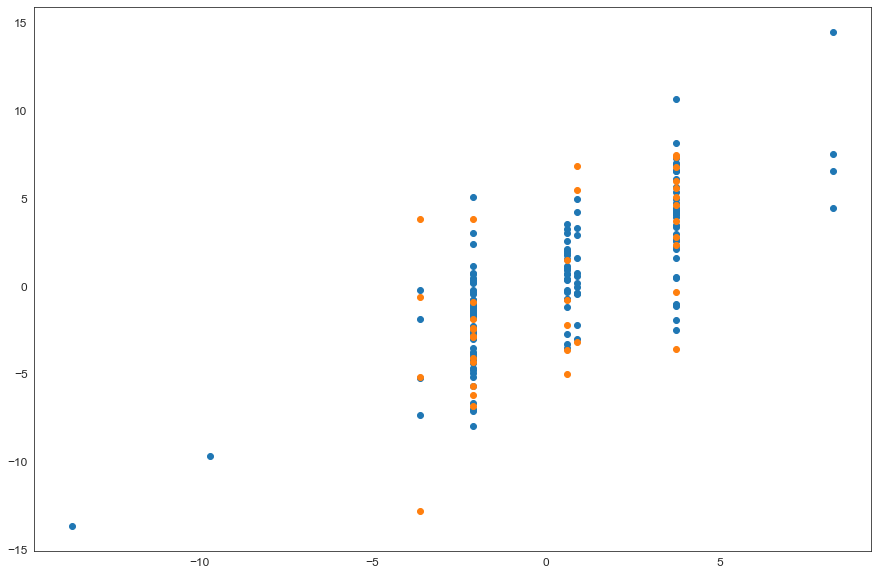

In [79]:
# Plot predicted against actual values

from matplotlib import pyplot as plt

# Use the best max_depth 
decision_tree_ISE = DecisionTreeRegressor(max_depth=3)  # fill in best max depth here
decision_tree_ISE.fit(train_feature, train_target)

# Predict values for train and test
train_prediction = decision_tree_ISE.predict(train_feature)
test_prediction = decision_tree_ISE.predict(test_feature)

# Scatter the predictions vs actual values
plt.scatter(train_prediction, train_target, label='train')  # blue
plt.scatter(test_prediction, test_target, label='test')  # orange
plt.show()

In [80]:
from sklearn import tree

listacaract=list(df1_ISE.columns.values)
respuesta=listacaract.pop()
text_representation = tree.export_text(decision_tree_ISE)
print(text_representation)

|--- feature_12 <= -0.26
|   |--- feature_1 <= -0.08
|   |   |--- feature_2 <= 4.24
|   |   |   |--- value: [0.61]
|   |   |--- feature_2 >  4.24
|   |   |   |--- value: [-3.63]
|   |--- feature_1 >  -0.08
|   |   |--- feature_0 <= 1.04
|   |   |   |--- value: [3.76]
|   |   |--- feature_0 >  1.04
|   |   |   |--- value: [8.28]
|--- feature_12 >  -0.26
|   |--- feature_1 <= -7.14
|   |   |--- feature_11 <= 2.04
|   |   |   |--- value: [-13.64]
|   |   |--- feature_11 >  2.04
|   |   |   |--- value: [-9.67]
|   |--- feature_1 >  -7.14
|   |   |--- feature_7 <= -2.85
|   |   |   |--- value: [0.89]
|   |   |--- feature_7 >  -2.85
|   |   |   |--- value: [-2.12]



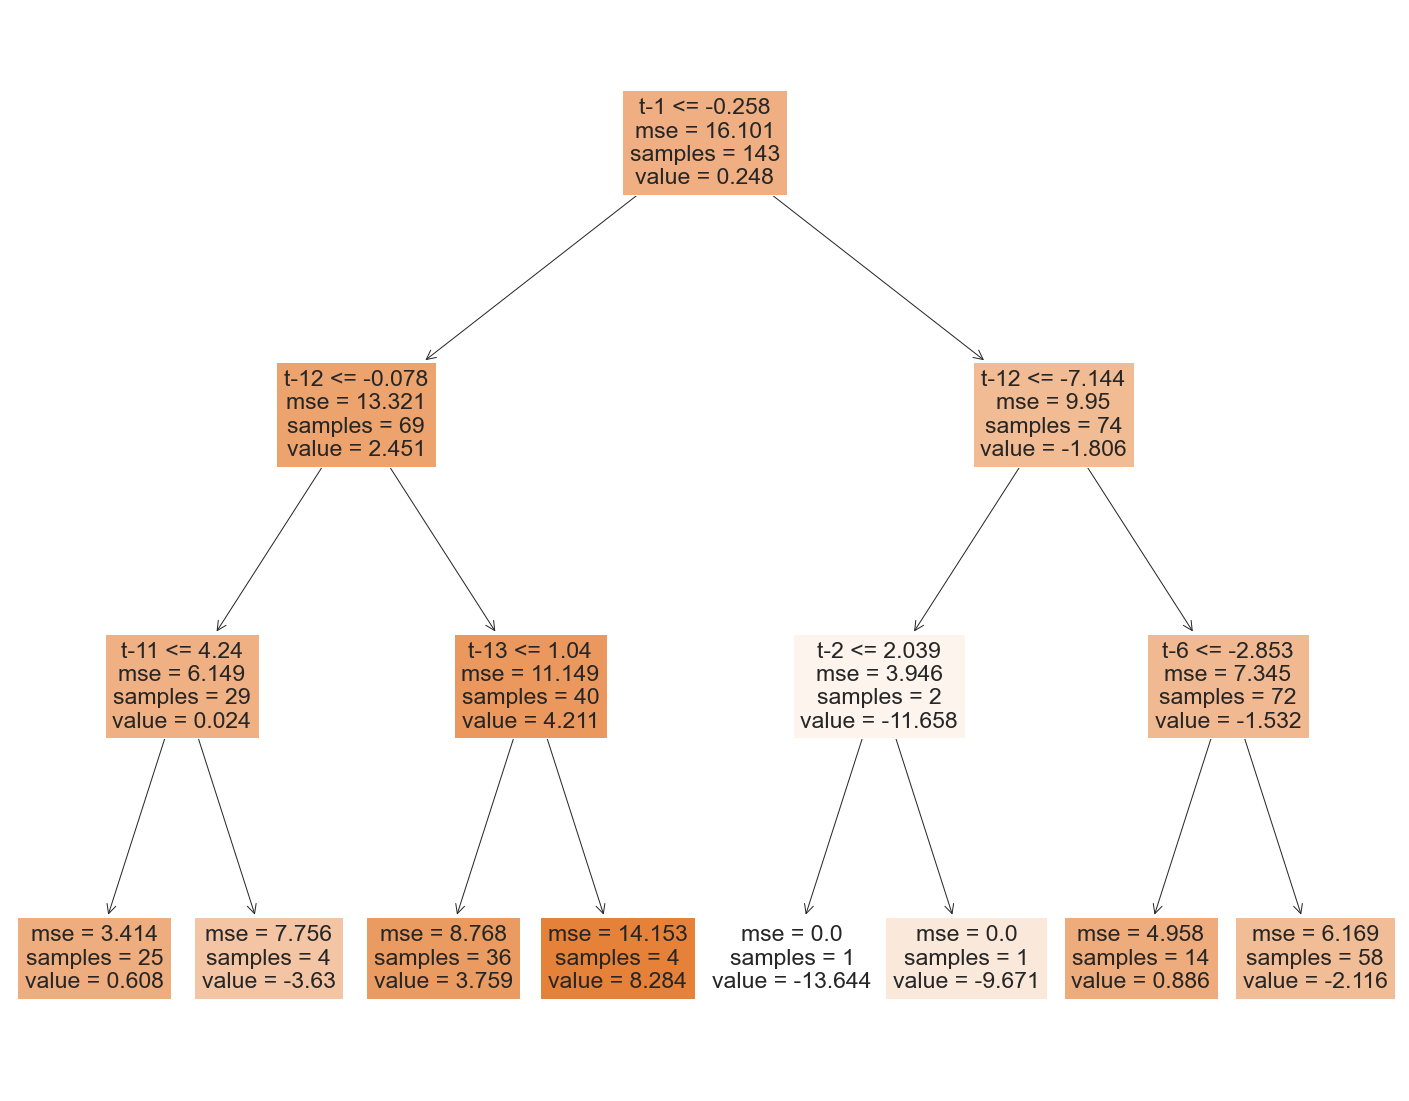

In [81]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_tree_ISE, 
                   feature_names=listacaract,  
                   class_names=respuesta,
                   filled=True)

Verficando las dimensiones del conjunto de prueba y del conjunto de entrenamiento para hacer las gráficas de comparación entre los verdaderos valores y sus pronósticos.

In [82]:
print(train_prediction.size)
print(train_target.size)

print(test_prediction.size)
print(test_target.size)

143
143
36
36


In [83]:
indicetrian_test=df1_ISE.index
print(indicetrian_test.size)  ###Tamaño del índice
indicetrain=indicetrian_test[0:142]
indicetest=indicetrian_test[142:178]

179


In [84]:
print(indicetrain.size)
print(indicetest.size)

142
36


In [85]:
targetjoint=np.concatenate((train_target,test_target))
predictionjoint=np.concatenate((train_prediction,test_prediction))
print(targetjoint.size)
print(predictionjoint.size)

179
179


In [86]:
d = {'observado': targetjoint, 'Predicción': predictionjoint}
ObsvsPred=pd.DataFrame(data=d,index=indicetrian_test)
ObsvsPred.head(10)

,observado,Predicción
2006-03-31,1.586562,0.608074
2006-04-30,-0.986623,-2.115819
2006-05-31,3.275833,0.608074
2006-06-30,-2.914964,-2.115819
2006-07-31,6.602706,8.283937
2006-08-31,0.754063,0.886260
2006-09-30,-0.790155,-2.115819
2006-10-31,0.439030,0.608074
2006-11-30,-0.789528,-2.115819
2006-12-31,-1.074300,3.758945


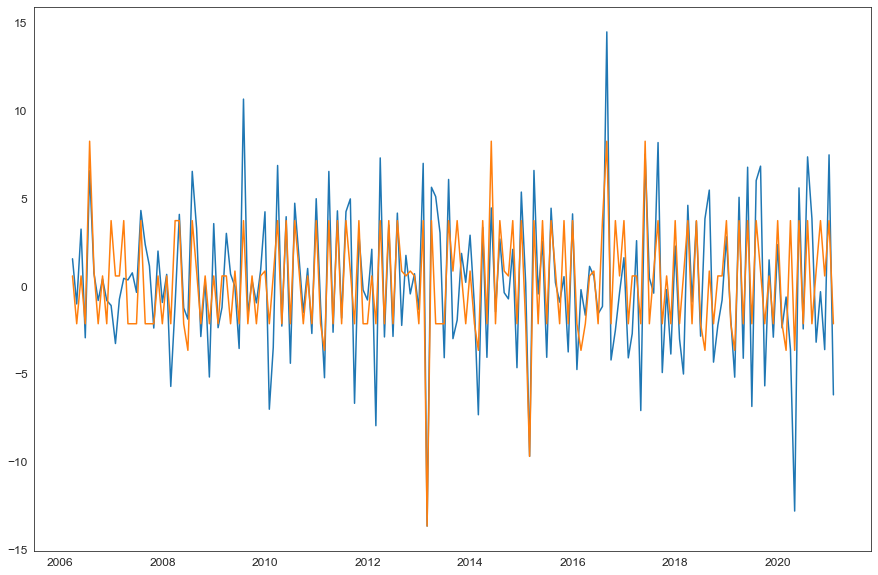

In [87]:
plt.plot(ObsvsPred)

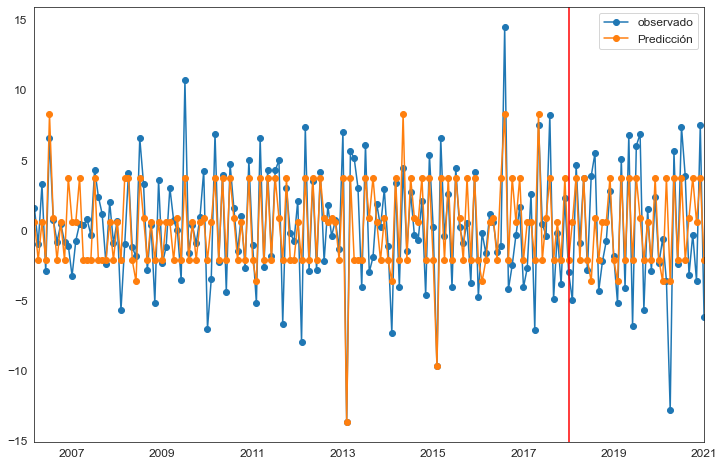

In [88]:
ax = ObsvsPred.plot( marker="o", figsize=(12,8))
ax.axvline(x=indicetrian_test[142].date(),color='red')

Obtener pronosticos de la serie real para poder interpretar, entonces nos devolvemos aplicando la transformación "inversa"

In [104]:
x = np.array(test_prediction)
len(x)
predictionreal = np.concatenate(([103.9801115485476], x)).cumsum()

y = np.array(test_target)
len(y)
targetreal = np.concatenate(([103.9801115485476], y)).cumsum()

36

36

In [106]:
d = {'observado real': targetreal, 'Predicción real': predictionreal}
ObsvsPredr=pd.DataFrame(data=d,index=indicetrian_test[141:178])
ObsvsPredr.head(10)

,observado real,Predicción real
2017-12-31,103.980112,103.980112
2018-01-31,98.999950,104.588185
2018-02-28,103.631027,108.347131
2018-03-31,102.762642,106.231311
2018-04-30,106.485796,109.990257
2018-05-31,103.661761,107.874437
2018-06-30,107.527335,104.244500
2018-07-31,113.026686,105.130760
2018-08-31,108.724614,103.014941
2018-09-30,106.525406,103.623014


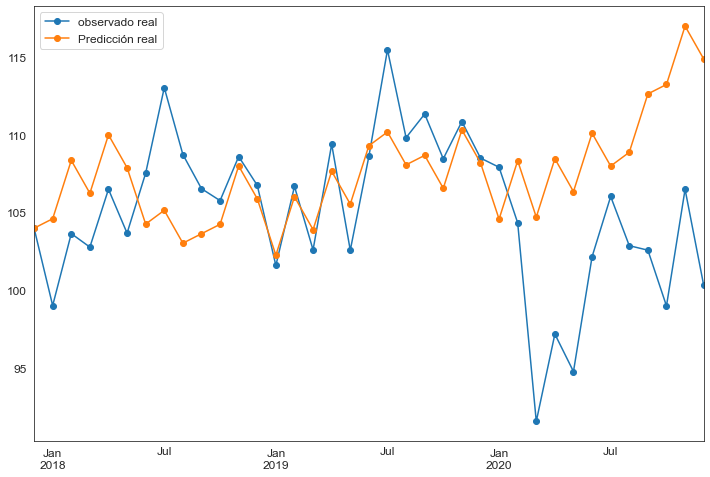

In [107]:
ax = ObsvsPredr.plot( marker="o", figsize=(12,8))

### Redes neuronales
Aqui tambien se necesita (o se prefiere) una serie sin tendencia o diferenciada, sin embargo para los pronosticos debemos devolvernos y ojo en la separación de datos con no poner el shuffle

In [34]:
print(df1_ISE.head(7))
df1_ISE.shape

                t-13      t-12      t-11      t-10       t-9       t-8  \
2006-03-31 -4.029199 -0.161871  3.858710 -1.216335  1.663566  0.987467   
2006-04-30 -0.161871  3.858710 -1.216335  1.663566  0.987467  3.023846   
2006-05-31  3.858710 -1.216335  1.663566  0.987467  3.023846 -1.630526   
2006-06-30 -1.216335  1.663566  0.987467  3.023846 -1.630526 -0.710640   
2006-07-31  1.663566  0.987467  3.023846 -1.630526 -0.710640 -0.528734   
2006-08-31  0.987467  3.023846 -1.630526 -0.710640 -0.528734  2.890303   
2006-09-30  3.023846 -1.630526 -0.710640 -0.528734  2.890303 -3.024170   

                 t-7       t-6       t-5       t-4       t-3       t-2  \
2006-03-31  3.023846 -1.630526 -0.710640 -0.528734  2.890303 -3.024170   
2006-04-30 -1.630526 -0.710640 -0.528734  2.890303 -3.024170 -3.868194   
2006-05-31 -0.710640 -0.528734  2.890303 -3.024170 -3.868194  1.586562   
2006-06-30 -0.528734  2.890303 -3.024170 -3.868194  1.586562 -0.986623   
2006-07-31  2.890303 -3.024170 -3.868

(179, 14)

#### Dividimos la data

In [35]:
# Split data

PRESsplit = df1_ISE.values
# split into lagged variables and original time series
X1= PRESsplit[:, 0:-1]  # slice all rows and start with column 0 and go up to but not including the last column
y1 =PRESsplit[:,-1]  # slice all rows and last column, essentially separating out 't' column

In [36]:
print(X1)
print(y1)

[[-4.02919937 -0.16187056  3.85870952 ...  2.89030299 -3.02417045
  -3.86819427]
 [-0.16187056  3.85870952 -1.21633532 ... -3.02417045 -3.86819427
   1.58656192]
 [ 3.85870952 -1.21633532  1.66356588 ... -3.86819427  1.58656192
  -0.98662339]
 ...
 [ 1.52194218 -2.88069634  2.39463136 ...  3.87805848 -3.16639131
  -0.29031728]
 [-2.88069634  2.39463136 -2.34917623 ... -3.16639131 -0.29031728
  -3.58945322]
 [ 2.39463136 -2.34917623 -0.5931444  ... -0.29031728 -3.58945322
   7.50609461]]
[ 1.58656192e+00 -9.86623391e-01  3.27583284e+00 -2.91496392e+00
  6.60270627e+00  7.54063421e-01 -7.90154676e-01  4.39029599e-01
 -7.89527588e-01 -1.07430017e+00 -3.24284970e+00 -7.18703974e-01
  4.71039634e-01  3.81787647e-01  7.84644624e-01 -3.26448142e-01
  4.33660320e+00  2.40136305e+00  1.17774677e+00 -2.36090565e+00
  2.02562111e+00 -9.03655089e-01  6.95372019e-01 -5.68577871e+00
 -9.97214232e-01  4.11571046e+00 -1.21125914e+00 -1.85344452e+00
  6.56559422e+00  3.31595301e+00 -2.84406279e+00  4.1

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [38]:
X_train, X_val, y_train, y_val=train_test_split(X1,y1,test_size=0.2, train_size=0.8, shuffle=False)

In [39]:
print(X_train.shape) #80% DEL 90%
print(X_val.shape)   #20 DEL 90%

print(y_train.shape)
print(y_val.shape)

(143, 13)
(36, 13)
(143,)
(36,)


#### Normalización de las covariables

In [40]:
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_val=scaler.transform(X_val)

X_train

array([[0.34149513, 0.47885202, 0.62165198, ..., 0.58725684, 0.37719099,
        0.34721359],
       [0.47885202, 0.62165198, 0.44140033, ..., 0.37719099, 0.34721359,
        0.54095154],
       [0.62165198, 0.44140033, 0.54368651, ..., 0.34721359, 0.54095154,
        0.44955907],
       ...,
       [0.39630366, 0.47300229, 0.54304312, ..., 0.77608629, 0.31070624,
        0.47859944],
       [0.47300229, 0.54304312, 0.34041169, ..., 0.31070624, 0.47859944,
        0.34818182],
       [0.54304312, 0.34041169, 0.38955486, ..., 0.47859944, 0.34818182,
        0.56672041]])

In [41]:
import tensorflow.keras as keras

model=keras.models.Sequential([keras.layers.Dense(32,activation="relu",input_shape=X_train.shape[1:]),keras.layers.Dense(1)])
#primera capa oculta con 32 unidades, fun. relu y dimensión de entrada    
#capa de salida con una de salida
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [42]:
# ESCOGEMOS LA FUNCION DE PERDIDA Y OPTIMIZADOR
model.compile(loss="mean_squared_error",optimizer="sgd")
# LO AJUSTAMOS
history=model.fit(X_train,y_train,epochs=50,validation_data=(X_val,y_val))

Epoch 1/50
5/5 [==============================] - 1s 129ms/step - loss: 16.5272 - val_loss: 22.7717
Epoch 2/50
5/5 [==============================] - 0s 11ms/step - loss: 15.1229 - val_loss: 22.5335
Epoch 3/50
5/5 [==============================] - 0s 10ms/step - loss: 15.1916 - val_loss: 22.3155
Epoch 4/50
5/5 [==============================] - 0s 10ms/step - loss: 12.9004 - val_loss: 22.1421
Epoch 5/50
5/5 [==============================] - 0s 11ms/step - loss: 13.9234 - val_loss: 21.8875
Epoch 6/50
5/5 [==============================] - 0s 11ms/step - loss: 16.0272 - val_loss: 21.6702
Epoch 7/50
5/5 [==============================] - 0s 12ms/step - loss: 15.2999 - val_loss: 21.5667
Epoch 8/50
5/5 [==============================] - 0s 11ms/step - loss: 16.4961 - val_loss: 21.5417
Epoch 9/50
5/5 [==============================] - 0s 13ms/step - loss: 16.1324 - val_loss: 21.1402
Epoch 10/50
5/5 [==============================] - 0s 12ms/step - loss: 15.0157 - val_loss: 20.9040
Epoch 11

<AxesSubplot:>

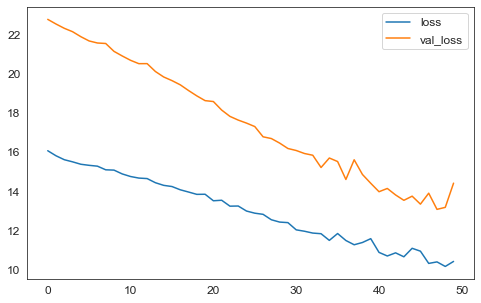

In [43]:
pd.DataFrame(history.history).plot(figsize=(8,5))

In [44]:
mse_test=model.evaluate(X_val,y_val)
print(mse_test)

2/2 [==============================] - 0s 2ms/step - loss: 14.4221
14.422117233276367


In [45]:
#COMO HAY MUY POCOS DATOS ENTONCES REPETIMOS XVAL?
ypred=model.predict(X_val)
print(ypred)

[[-0.08646917]
 [ 4.720828  ]
 [-2.2810917 ]
 [ 3.9639823 ]
 [-0.10018825]
 [ 1.1913533 ]
 [ 3.171031  ]
 [-2.4858575 ]
 [ 2.6525254 ]
 [-0.18802816]
 [ 2.6472125 ]
 [-0.2918309 ]
 [-0.6315913 ]
 [ 4.625121  ]
 [-0.4344102 ]
 [ 3.5587347 ]
 [-1.9526027 ]
 [ 3.545051  ]
 [ 1.7536145 ]
 [-2.1465766 ]
 [ 2.6109407 ]
 [-0.6481762 ]
 [ 3.6522272 ]
 [-0.26446593]
 [-0.8778583 ]
 [ 4.2298536 ]
 [-0.05279159]
 [ 6.6916428 ]
 [-2.4289913 ]
 [ 2.8863776 ]
 [ 1.243272  ]
 [-1.0516409 ]
 [ 4.1970778 ]
 [-1.0909562 ]
 [ 2.7399502 ]
 [-2.5160458 ]]


<Figure size 432x432 with 0 Axes>

Text(0.5, 1.0, 'Actual vs Predicted Air Pressure')

Text(0, 0.5, 'Air Pressure')

Text(0.5, 0, 'Index')

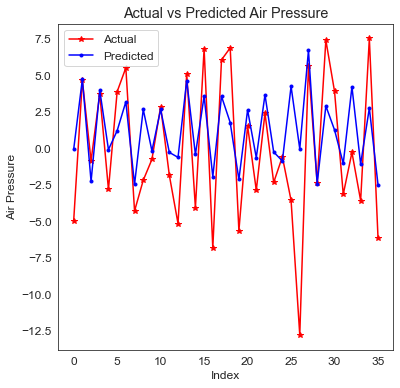

In [46]:
plt.figure(figsize=(6, 6))
plt.plot(range(y_val.size), y_val, linestyle='-', marker='*', color='r')
plt.plot(range(ypred.size), ypred, linestyle='-', marker='.', color='b') 
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Actual vs Predicted Air Pressure')
plt.ylabel('Air Pressure')
plt.xlabel('Index')

In [50]:
x = np.array(test_prediction)
len(x)
predictionreal = np.concatenate(([103.9801115485476], x)).cumsum()

y = np.array(test_target)
len(y)
targetreal = np.concatenate(([103.9801115485476], y)).cumsum()
type(ypred)

numpy.ndarray

In [68]:
ypredr = DataFrame()

for i in range(1,35):
        ypredr[[0]] = 103.9801115485476
        ypredr[i] = ypred[i] + ypred[i-1]
        
print(ypredr.values)

[[103.98011155   4.63435888   2.43973637   1.68289065   3.86379409
    1.09116507   4.36238432   0.68517351   0.16666794   2.46449733
    2.45918441   2.35538149  -0.92342222   3.9935298    4.19071102
    3.12432432   1.60613191   1.59244835   5.29866552  -0.3929621
    0.46436405   1.9627645    3.00405097   3.38776112  -1.14232421
    3.35199547   4.17706203   6.63885117   4.26265144   0.45738626
    4.12964964   0.19163108   3.14543676   3.10612154   1.64899397]]
